## ARM 

In [13]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 


## 6.1.1: Read and clean novel

* The following code is needed to read, clean, and convert the novel into a format suitable for ARM 
* Various chunks of code are missing, your job is to complete them based on the comments 


In [14]:
# Convert lyrics column to a txt file

df = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/final_df.csv')

np.savetxt("/Users/anthonymoubarak/Desktop/song_lyrics.txt" , df['lyrics'] ,  fmt='%s')

In [15]:
#USER PARAM
input_path			=	'/Users/anthonymoubarak/Desktop/song_lyrics.txt'
compute_sentiment 	=	True		
sentiment    		=	[]			#average sentiment of each chunck of text 
ave_window_size		=	250			#size of scanning window for moving average
					

#OUTPUT FILE
output='transactions.txt'
if os.path.exists(output): os.remove(output)

#INITIALIZE
lemmatizer 	= 	WordNetLemmatizer()
ps 			=	PorterStemmer()
sia 		= 	SentimentIntensityAnalyzer()

#ADD MORE
stopwords	=	stopwords.words('english')
add=['mr','mrs','wa','dr','said','back','could','one','looked','like','know','around','dont']
for sp in add: stopwords.append(sp)

def read_and_clean(path,START=0,STOP=-1):
	global sentiment 

	#-----------------------
	#INSERT CODE TO READ IN AS ONE BIG STING
	#-----------------------

	file=open(path, 'rt', encoding='utf-8')
	text=file.read().lower()
	file.close()

	#REMOVE HEADER, AND NEW LINES
	text=text.replace("'",'') #wasn't --> wasnt
	lines = text.splitlines(); text=''; 
	lines=lines[START:STOP]    # mystring.replace('\n', ' ')
	for line in lines: text=text+' '+line

	#-----------------------
	#INSERT CODE TO ONLY KEEP CHAR IN string.printable
	#-----------------------

	tmp=''
	printable = set(string.printable)
	for char in text:
		if(char in printable):
			tmp=tmp+char
	text=tmp

	#BREAK INTO CHUNKS (SENTANCES OR OTHERWISE)
	sentences=nltk.tokenize.sent_tokenize(text)  #SENTENCES

	print("NUMBER OF SENTENCES FOUND:",len(sentences)); #print(sentences)

	#CLEAN AND LEMMATIZE
	keep='0123456789abcdefghijklmnopqrstuvwxy';

	new_sentences=[]; vocabulary=[]
	for sentence in sentences:
		new_sentence=''

		# REBUILD LEMITIZED SENTENCE
		for word in sentence.split():
			
			#ONLY KEEP CHAR IN "keep"
			tmp2=''
			for char in word: 
				if(char in keep): 
					tmp2=tmp2+char
				else:
					tmp2=tmp2+' '
			word=tmp2

			#-----------------------
			# INSERT CODE TO LEMMATIZE THE WORDS
			#-----------------------

			new_word = lemmatizer.lemmatize(word)

			#REMOVE WHITE SPACES
			new_word=new_word.replace(' ', '')

			#BUILD NEW SENTANCE BACK UP
			if( new_word not in stopwords):
				if(new_sentence==''):
					new_sentence=new_word
				else:
					new_sentence=new_sentence+','+new_word
				if(new_word not in vocabulary): vocabulary.append(new_word)

		#SAVE (LIST OF LISTS)		
		new_sentences.append(new_sentence.split(","))
		
		#SIA
		if(compute_sentiment):
			#-----------------------
			# INSERT CODE TO USE NLTK TO DO SENTIMENT ANALYSIS 
			#-----------------------

			text_ =new_sentence.replace(',', ' ')
			ss = sia.polarity_scores(text_)
			sentiment.append([ss['neg'], ss['neu'], ss['pos'], ss['compound']])
			
		#SAVE SENTANCE TO OUTPUT FILE
		if(len(new_sentence.split(','))>2):
			f = open(output, "a")
			f.write(new_sentence+"\n")
			f.close()

	sentiment=np.array(sentiment)
	print("TOTAL AVERAGE SENTEMENT:",np.mean(sentiment,axis=0))
	print("VOCAB LENGTH",len(vocabulary))
	return new_sentences




In [16]:
transactions=read_and_clean(input_path,400,-400)
# transactions[:5]
texT = pd.DataFrame(transactions)
texT.head()

NUMBER OF SENTENCES FOUND: 17187
TOTAL AVERAGE SENTEMENT: [0.10906127 0.67604131 0.19319573 0.1549408 ]
VOCAB LENGTH 22582


,0,1,2,3,4,5,6,7,8,9,...,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930
0,friend,crowd,id,turn,need,ruled,earth,would,life,worth,...,None,None,None,None,None,None,None,None,None,None
1,ever,pair,eye,promised,paradise,jeebel,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,ever,devil,plan,made,torment,man,decieving,grieving,leaving,blue,...,None,None,None,None,None,None,None,None,None,None
3,ever,devil,born,without,pair,horn,jeebel,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,ever,pair,eye,promised,paradise,jeebel,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## 

## Lab-6.1.3: Re-format output

In [17]:
# INSERT CODE TO RE-FORMAT THE APRIORI OUTPUT INTO A PANDAS DATA-FRAME WITH COLUMNS "rhs","lhs","supp","conf","supp x conf","lift"


def reformat_apriori_output(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
 
        for j in range(0,len(list(results[i]))):
       
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                         
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

## Utility function: Convert to NetworkX object

In [18]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G


## Utility function: Plot NetworkX object

In [19]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Dracula')
    plt.show()

# raise

## 6.1.4: Train ARM model 

In [56]:
# INSERT CODE TO TRAIN THE ARM MODEL USING THE "apriori" PACKAGE

print("Transactions:",texT)
# Run Apriori algorithm
results = list(apriori(transactions, min_support=0.02, min_confidence=0.65, min_length=1, max_length=2)) 
result_df = reformat_apriori_output(results)
print("Results\n",len(results))

Transactions:             0          1        2           3         4          5     \
0         friend      crowd       id        turn      need      ruled   
1           ever       pair      eye    promised  paradise     jeebel   
2           ever      devil     plan        made   torment        man   
3           ever      devil     born     without      pair       horn   
4           ever       pair      eye    promised  paradise     jeebel   
...          ...        ...      ...         ...       ...        ...   
17182  everybody        got    small        town    anthem  everybody   
17183       yeah      whats  country  song2embed    arcade      lyric   
17184     giving          u    didnt        take       lot        saw   
17185      matas        sin       un     pistoln        yo         te   
17186     rockin  christmas     tree       happy   holiday  everyones   

            6         7        8          9     ...  1921  1922  1923  1924  \
0          earth     would    

## Lab-6.1.5: Visualize the results

          rhs     lhs      supp      conf  supp x conf      lift
0     [alone]    [im]  0.024204  0.703892     0.017037  3.308118
1    [always]    [im]  0.029499  0.662745     0.019550  3.114739
2    [always]  [love]  0.028975  0.650980     0.018862  3.310178
3       [bad]    [im]  0.023157  0.678024     0.015701  3.186545
4   [believe]    [im]  0.025368  0.715928     0.018162  3.364684
..        ...     ...       ...       ...          ...       ...
61    [youll]    [im]  0.025077  0.670295     0.016809  3.150224
62   [inside]  [love]  0.021819  0.680581     0.014849  3.460693
63     [mine]  [love]  0.021819  0.660211     0.014405  3.357116
64     [true]  [love]  0.023332  0.748134     0.017455  3.804197
65    [youll]  [love]  0.025543  0.682737     0.017439  3.471658

[66 rows x 6 columns]
DiGraph with 61 nodes and 66 edges


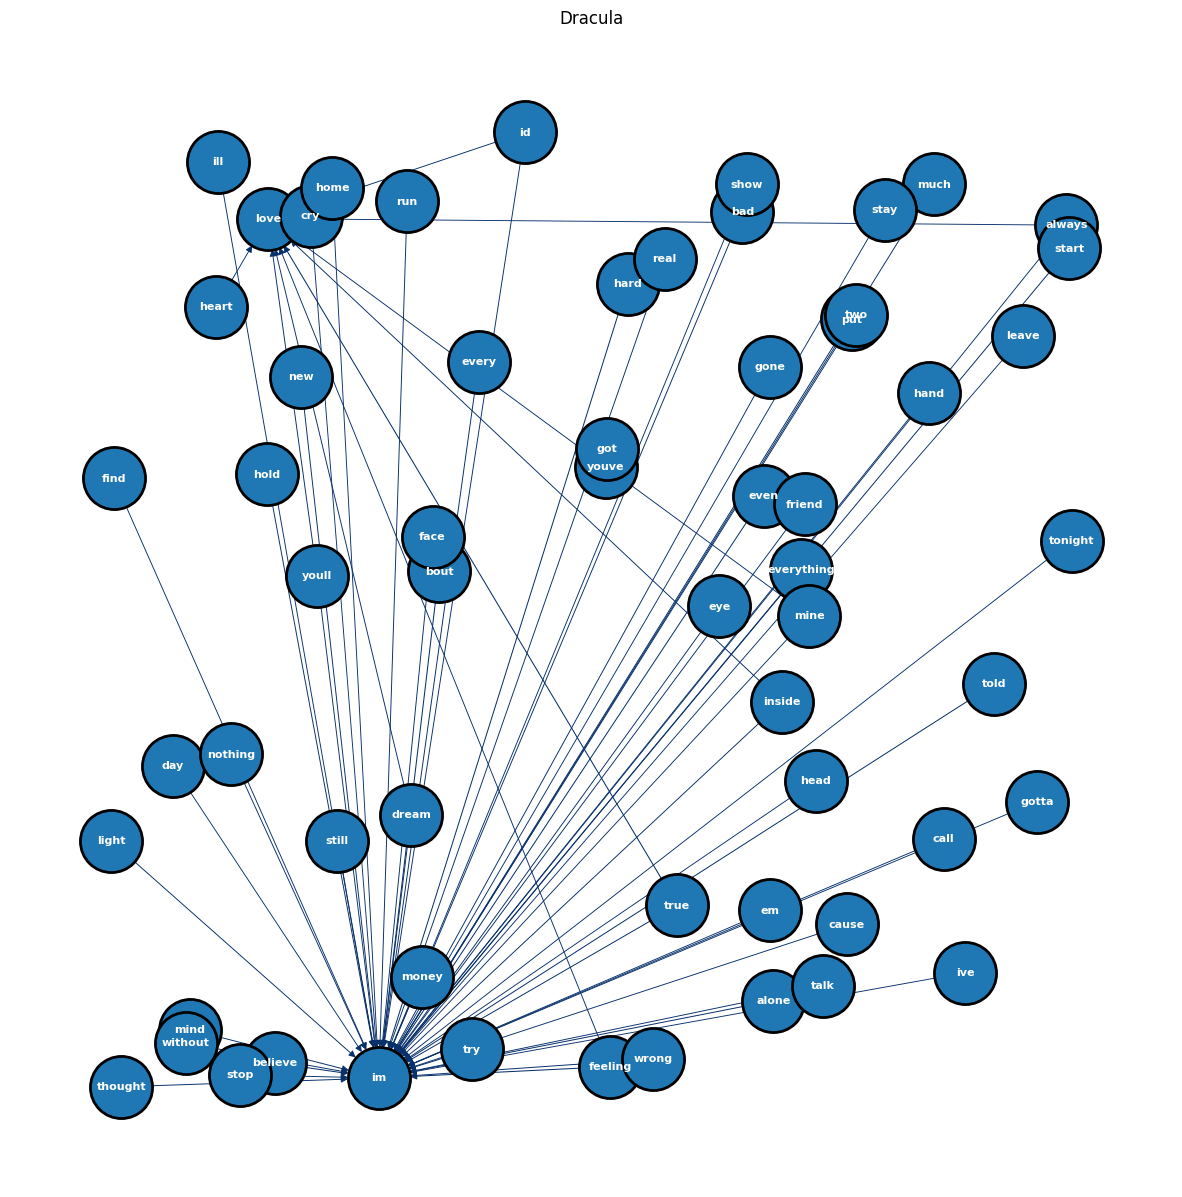

In [57]:
# INSERT CODE TO PLOT THE RESULTS AS A NETWORK-X OBJECT 

pd_results = reformat_apriori_output(results)
# print("Results\n", pd_results)
result_network = convert_to_network(result_df)
print(result_network)
plot_network(result_network)